In [1]:
import numpy as np
import scipy as sp
import getopt
from tqdm import tqdm
import os
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def correlation_matrix(m):
    """Calculates the correlation matrix of matrix m_ij."""
    avg = np.average(m, axis=0)
    dim = len(avg)
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # VARIATION
    sigma = []
    for i in range(dim):
        sigma.append(np.sum((avg[i] - m[i])**2))
    sigma = np.sqrt(sigma)
    
    sigma_bis = []
    for i in range(dim):
        cum = 0
        for j in range(len(m[i])):
            cum += (avg[i] - m[i][j])**2
        sigma_bis.append(cum)
    sigma_bis = np.sqrt(sigma_bis)        
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # CORRELATION MATRIX
    CORR = np.zeros((dim, dim))
    for i in range(dim):
        for j in range(dim):
            cum = 0
            for k in range(len(m[i])):
                cum += (avg[i] - m[i][k])*(avg[j] - m[j][k])
            CORR[i, j] = cum  / (sigma_bis[i] * sigma_bis[j])

    if np.linalg.det(CORR) == 0:
        print("¶ WARNING: correlation matrix is singular")
    
    return CORR

def Hartlap(mat, Nr = 350):
    """Calculates inverse matrix using Hartlap correction.
    Arguments:
    - `mat`: input matrix to invert
    - `Nr`: nuber of realization used o calculated the matrix
    """
    return (Nr-len(mat)-2)/(Nr-1)*np.linalg.inv(mat)

def info_name(name):
    """Obtain realization information from namefile"""
    print("TYPE: ", type(name))
    info = name.split('_')[-3:]
    print("TYPE: ", info, "\n", type(info))
    info[2] = info[2].replace(".wst", "")
    N_hgrid = info[0]
    N_WSTgrid = info[1]
    n_realiz = info[2].replace(".wst", "")
    
    return [int(N_hgrid), int(N_WSTgrid), int(n_realiz)]

def cosmo_parser(name):
    """Obtain cosmology from .wst file"""
    info = name.split('_')
    if info[0] == "fiducial":
        return info[0]
    elif info[0] == "zeldovich":
        return info[0]
    else:
        return info[0] + "_" + info[1]

In [3]:
order_folders = {
    'fiducial'  : 0,
    'h_m'       : 1,
    'h_p'       : 2,
    'Mnu_p'     : 3,
    'Mnu_pp'    : 4,
    'Mnu_ppp'   : 5,
    'ns_m'      : 6,
    'ns_p'      : 7,
    'Ob2_m'     : 8,
    'Ob2_p'     : 9,
    'Om_m'      : 10,
    'Om_p'      : 11,
    's8_m'      : 12,
    's8_p'      : 13,
    'w_m'       : 14,
    'w_p'       : 15,
    'zeldovich' : 16
}

cosmological_pars = {
    'Om'  : 0,
    'Ob'  : 1,
    'h'   : 2,
    'ns'  : 3,
    's8'  : 4,
    'w'   : 5,
    'Mnu' : 6
}

order_dimension = {
    'Om'  : 0,
    'Ob'  : 1,
    'Ob2' : 1,
    'h'   : 2,
    'ns'  : 3,
    's8'  : 4,
    'w'   : 5,
    'Mnu' : 6
}

COSMOPAR = {
#                   | Om   | Ob   |   h   |  n_s  | s_8 | Mnu | w |

    'fiducial' :    [0.3175, 0.049, 0.6711, 0.9624, 0.834, 0, -1],
    'zeldovich':    [0.3175, 0.049, 0.6711, 0.9624, 0.834, 0, -1],
    
    'Mnu_p' :       [0.3175, 0.049, 0.6711, 0.9624, 0.834, 0.1, -1],
    'Mnu_pp' :      [0.3175, 0.049, 0.6711, 0.9624, 0.834, 0.2, -1],
    'Mnu_ppp' :     [0.3175, 0.049, 0.6711, 0.9624, 0.834, 0.4, -1],
    
    'h_m' :         [0.3175, 0.049, 0.6511, 0.9624, 0.834, 0, -1],
    'h_p' :         [0.3175, 0.049, 0.6911, 0.9624, 0.834, 0, -1],
    
    'ns_m' :        [0.3175, 0.049, 0.6711, 0.9424, 0.834, 0, -1],
    'ns_p' :        [0.3175, 0.049, 0.6711, 0.9824, 0.834, 0, -1],
    
    'Ob_m' :        [0.3175, 0.048, 0.6711, 0.9624, 0.834, 0, -1],
    'Ob_p' :        [0.3175, 0.050, 0.6711, 0.9624, 0.834, 0, -1],
    'Ob2_m' :       [0.3175, 0.047, 0.6711, 0.9624, 0.834, 0, -1],
    'Ob2_p' :       [0.3175, 0.051, 0.6711, 0.9624, 0.834, 0, -1],
    
    'Om_m' :        [0.3075, 0.049, 0.6711, 0.9624, 0.834, 0, -1],
    'Om_p' :        [0.3275, 0.049, 0.6711, 0.9624, 0.834, 0, -1],
    
    's8_m' :        [0.3175, 0.049, 0.6711, 0.9624, 0.819, 0, -1],
    's8_p' :        [0.3175, 0.049, 0.6711, 0.9624, 0.849, 0, -1],
    
    'w_m' :         [0.3175, 0.049, 0.6711, 0.9624, 0.834, 0, -0.95],
    'w_p' :         [0.3175, 0.049, 0.6711, 0.9624, 0.834, 0, -1.05]
}
"""
Dictionary to assegnate to a cosmology its parameters
Ordered pairing cosmologies and the first one in with _m, the second one _p
"""

VarCosmoPar = {
    'd_h'  : 0.02,
    'd_ns' : 0.02,
    'd_Ob' : 0.001,
    'd_Ob2': 0.002,
    'd_Om' : 0.01,
    'd_s8' : 0.015,
    'd_w'  : -0.05
}
"""Values of deviations from fiducial cosmological parameters.
"""

fiducial_vals = {
    'Ob'  : 0.3175,
    'Ob2' : 0.3175,
    'Om'  : 0.049,
    'h'   : 0.6711,
    'n_s' : 0.9624,
    'ns'  : 0.9624,
    's_8' : 0.834,
    's8'  : 0.834,
    'Mnu' : 0,
    'w'   : -1
}
"""Values of fiducial cosmological parameters.
"""

'Values of fiducial cosmological parameters.\n'

In [4]:
root = "/home/fuffolo97/TESI/WST-files_08_08/WST-files_08_08/"
folders = ['fiducial', 'zeldovich', 'h_m', 'h_p', 'Mnu_p', 'Mnu_pp' ,'Mnu_ppp', \
           'ns_m', 'ns_p', 'Ob2_m', 'Ob2_p', \
           'Om_m', 'Om_p', 's8_m', 's8_p', 'w_m', 'w_p']
cosmologies = ['fiducial', 'zeldovich', 'h_m', 'h_p', 'Mnu_p', 'Mnu_pp' ,'Mnu_ppp', \
           'ns_m', 'ns_p', 'Ob2_m', 'Ob2_p', \
           'Om_m', 'Om_p', 's8_m', 's8_p', 'w_m', 'w_p']

fiducial_coeffs = []
zeldovich_coeffs = []

In [5]:
coeffs_tot = np.zeros((len(cosmologies), 75))
files_to_read_raw = os.listdir(root)
files_to_read = []
for i in range(len(files_to_read_raw)):
    if "400" not in files_to_read_raw[i] and "_RDs_" not in files_to_read_raw[i]: files_to_read.append(files_to_read_raw[i])
# files_to_read

In [6]:
coeffs_tot = np.zeros((len(cosmologies), 75))
files_to_read_raw = os.listdir(root)
files_to_read = []
for i in range(len(files_to_read_raw)):
    if "400" not in files_to_read_raw[i] and "_RDs_" not in files_to_read_raw[i]: files_to_read.append(files_to_read_raw[i])
print(files_to_read)

for i in range(len(files_to_read)):
    coeffs_cosm = []
    file_reading = files_to_read[i]

    cosmo = cosmo_parser(file_reading)
    assert cosmo in file_reading
    # print("COSMO KEY: ", cosmo)
    index = order_folders[cosmo]
    
    if ("fiducial" not in file_reading) and ("zeldovich" not in file_reading):
        # print("A, ", file_reading)
        with open(root + "/" + file_reading, 'rb') as Ff:
            while True:
                try:
                    coeffs_cosm.append(pickle.load(Ff))
                except EOFError:
                    break
                except RuntimeWarning:
                    print("problem here: ", file_reading)

    elif "fiducial" in file_reading:
        # print("B, ", file_reading)
        with open(root + "/" + file_reading, 'rb') as Ff:
            while True:
                try:
                    fiducial_coeffs.append(pickle.load(Ff))
                except EOFError:
                    break
                except RuntimeWarning:
                    print("problem here: ", file_reading)
        fiducial_coeffs_avg = np.average(fiducial_coeffs, axis=0)

        print(np.shape(fiducial_coeffs_avg))
        
        if len(fiducial_coeffs) == 0:
            print(cosmo, " has problem!")

    elif "zeldovich" in file_reading:
        # print("C, ", file_reading)
        with open(root + "/" + file_reading, 'rb') as Ff:
            while True:
                try:
                    zeldovich_coeffs.append(pickle.load(Ff))
                except EOFError:
                    break
                except RuntimeWarning:
                    print("problem here: ", file_reading)
        # print(zeldovich_coeffs)
        zeldovich_coeffs_avg = np.average(zeldovich_coeffs, axis=0)
        # print(zeldovich_coeffs_avg)
        print(np.shape(zeldovich_coeffs_avg))
    else:
        assert False, "\n   ERROR in reading WST files, cosmology can't be propely interpreted.\n"

    # USING average  value per coefficient in cosmology
    if len(coeffs_cosm) == 0 and cosmo != "fiducial" and cosmo != "zeldovich":
        print(cosmo, " has problem!")
        print(cosmo, " : ", np.shape(coeffs_cosm))
    if cosmo != "fiducial" and cosmo != "zeldovich":
        coeffs_tot[index] = np.average(coeffs_cosm, axis=0)

['Ob2_m_coefficients_M_Ns_s08_q08_256_350.wst', 'Om_m_coefficients_M_Ns_s08_q08_256_350.wst', 'Mnu_pp_coefficients_M_Ns_s08_q08_256_350.wst', 's8_p_coefficients_M_Ns_s08_q08_256_350.wst', 'w_p_coefficients_M_Ns_s08_q08_256_350.wst', 'Om_p_coefficients_M_Ns_s08_q08_256_350.wst', 'h_m_coefficients_M_Ns_s08_q08_256_350.wst', 'w_m_coefficients_M_Ns_s08_q08_256_350.wst', 'Ob2_p_coefficients_M_Ns_s08_q08_256_350.wst', 'ns_m_coefficients_M_Ns_s08_q08_256_350.wst', 'Mnu_p_coefficients_M_Ns_s08_q08_256_350.wst', 'Mnu_ppp_coefficients_M_Ns_s08_q08_256_350.wst', 'zeldovich_coefficients_M_Ns_s08_q08_256_500.wst', 'ns_p_coefficients_M_Ns_s08_q08_256_350.wst', 'fiducial_coefficients_M_Ns_s08_q08_256_1000.wst', 'h_p_coefficients_M_Ns_s08_q08_256_350.wst', 's8_m_coefficients_M_Ns_s08_q08_256_350.wst']
(75,)
(75,)


In [7]:
derivates = np.zeros((len(cosmological_pars), len(coeffs_tot[0])))
n_seen = 0

In [8]:
for i in cosmological_pars:
    if "Mnu" not in i and "Ob" not in i:
        ind = order_dimension[i]
        derivates[ind]=(coeffs_tot[order_folders[i+"_p"]]-coeffs_tot[order_folders[i+"_m"]])\
                    /  (2 * VarCosmoPar['d_'+i] * fiducial_vals[i] )
        assert derivates[order_dimension[i]].all() > 1e-3, f"Derivates of {i} is null"
    elif "Mnu" in i:
        # derivates[order_dimension['Mnu']] = \
        #     (coeffs_tot[order_folders['Mnu_ppp']] - 12 * coeffs_tot[order_folders['Mnu_pp']] + 32 * coeffs_tot[order_folders["Mnu_p"]] - 12 * coeffs_tot[order_folders['zeldovich']]) / (12 * COSMOPAR[i][5]) - \
        #     (coeffs_tot[order_folders["Mnu_pp"]] - 4 * coeffs_tot[order_folders['Mnu_p']] - 3 * coeffs_tot[order_folders['zeldovich']]) / (COSMOPAR[i][5]) + \
        #     (coeffs_tot[order_folders["Mnu_ppp"]] - coeffs_tot[order_folders['zeldovich']]) / COSMOPAR[i][5]
        # derivates[order_dimension['Mnu']] = (coeffs_tot[order_folders['Mnu_ppp']] - 12 * coeffs_tot[order_folders['Mnu_pp']] + 32 * coeffs_tot[order_folders["Mnu_p"]] - 12 * zeldovich_coeffs_avg) / (12 * COSMOPAR[i][5]) + \
        #     (-coeffs_tot[order_folders["Mnu_pp"]] + 4 * coeffs_tot[order_folders['Mnu_p']] - 3 * zeldovich_coeffs_avg) / (COSMOPAR[i][5]) + \
        #     (coeffs_tot[order_folders["Mnu_p"]] - zeldovich_coeffs_avg) / COSMOPAR[i][5]
        derivates[order_dimension['Mnu']] = (coeffs_tot[order_folders["Mnu_p"]] - zeldovich_coeffs_avg) / (0.1)
            # (coeffs_tot[order_folders['Mnu_ppp']] - 12 * coeffs_tot[order_folders['Mnu_pp']] + 32 * coeffs_tot[order_folders["Mnu_p"]] - 12 * zeldovich_coeffs_avg) / (12 * 0.1) + \
            # (-coeffs_tot[order_folders["Mnu_pp"]] + 4 * coeffs_tot[order_folders['Mnu_p']] - 3 * zeldovich_coeffs_avg) / (2*0.1) + \
            # (coeffs_tot[order_folders["Mnu_p"]] - zeldovich_coeffs_avg) / (0.1)
        # derivates[order_dimension['Mnu']] = (coeffs_tot[order_folders["Mnu_p"]] - zeldovich_coeffs_avg) / (0.1)
        assert derivates[order_dimension['Mnu']].all() > 1e-3, "Derivates of neutrino mass is null"
    elif "Ob" in i:
        derivates[order_dimension['Ob']] = \
            (coeffs_tot[order_folders[i+"2_p"]]-coeffs_tot[order_folders[i+"2_m"]]) \
              / (2 * VarCosmoPar['d_'+i+"2"] * fiducial_vals[i] )
        assert derivates[order_dimension['Ob']].all() > 1e-3, "Derivates of Omaga barion is null"

In [9]:
parameter_name = ['Om ', 'Ob ', 'h  ', 'ns ', 's8 ', 'w  ', 'Mnu']

In [10]:
CorrMat = correlation_matrix(fiducial_coeffs)
H = Hartlap(CorrMat, 1000)
Fish = np.zeros((7,7))
for a in range(7):
    for b in range(7):
        Fish[a, b] = np.sum(derivates[a] * H * derivates[b])

¶ WARNING: correlation matrix is singular


import scipy as sp
inverse = np.linalg.inv(Fi)
results = []
for i in range(len(inverse)):
    results.append(inverse[i, i])

In [11]:
corr = np.corrcoef(fiducial_coeffs)
H = Hartlap(CorrMat, 1000)
Fish = np.zeros((7,7))
for a in range(7):
    for b in range(7):
        Fish[a, b] = np.sum(derivates[a] * (H * derivates[b]))

In [12]:
inverse = np.linalg.inv(Fish)
results = []
for i in range(len(inverse)):
    results.append(inverse[i, i])

constrains = (sp.linalg.eig(inverse))[0]
constrains = constrains ** 0.5

for i in range(len(constrains)):
    print(parameter_name[i], ": ", constrains[i])

Om  :  1.5529175758844955e-08j
Ob  :  5.603864202919659e-09j
h   :  (4.418870546101451e-09+0j)
ns  :  1.800004997002961e-10j
s8  :  (1.7514715217856428e-10+0j)
w   :  (5.141183617002253e-13+0j)
Mnu :  4.3938332078403336e-12j


In [13]:
np.shape(corr)

(1000, 1000)

In [14]:
np.linalg.det(Fish)

1.3333325480728392e+135

# BEST PROPOSAL

In [15]:
# fids = np.array(fiducial_coeffs).reshape((75, 1000))
fids = np.array(fiducial_coeffs).transpose()
corr2 = np.corrcoef(fids)
cov2 = np.cov(fids)
# print(cov2)
# print(np.linalg.det(cov2))
# print(np.shape(cov2))
H2 = Hartlap(cov2, 1000)
Fish2 = np.zeros((7,7))
for a in range(7):
    for b in range(7):
        Fish2[a, b] = np.sum(derivates[a] * (H2 * derivates[b]))

In [16]:
inverse2 = np.linalg.inv(Fish2)
diagonal2 = []
for i in range(len(inverse2)):
    diagonal2.append(np.abs(inverse2[i, i])**0.5)
for i in range(len(diagonal2)):
    print(parameter_name[i], ": ", np.abs(diagonal2[i]))

Om  :  0.00048376555688353314
Ob  :  0.002274492036696267
h   :  0.04047173717133039
ns  :  0.00984716348567532
s8  :  0.011980583633679608
w   :  0.10279398346263864
Mnu :  0.10271430899558716


### DIAGONALIZING

constrains2 = (sp.linalg.eig(inverse2))[0]
constrains2 = constrains2 ** 0.5

for i in range(len(constrains2)):
    print(parameter_name[i], ": ", constrains2[i])
print()
for i in range(len(constrains2)):
    print(parameter_name[i], ": ", np.abs(constrains2[i]))

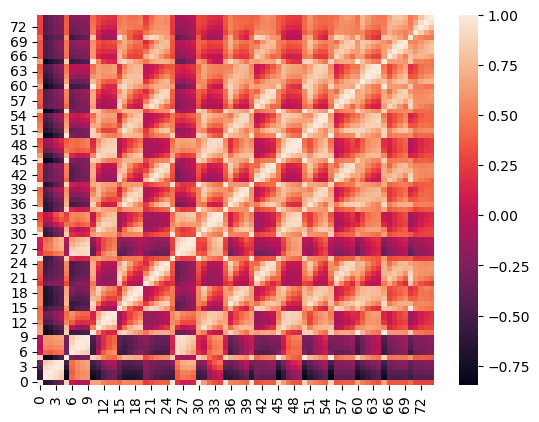

In [17]:
sns.heatmap(corr2.transpose())
plt.gca().invert_yaxis()